 In this tutorial, we will demonstrate how to implement a time-dependent simulation of hydrogen isotopes diffusion-trapping followed by Thermal Desorption Spectrometry (TDS). The aim is to replicate the experimental results presented in [Ogorodnikova _et al_ (J. Nucl. Mater. 313-316 (2003) 469-477.)](https://www.sciencedirect.com/science/article/pii/S0022311502013752?via%3Dihub) using FESTIM.

# 1. Setting the parameters,
The first step is to create a FESTIM Simulation object. The parameters needed for the simulation are added in the following steps.

In [ ]:
import FESTIM as F

my_model = F.Simulation()

FESTIM provides a simple way to define refined meshes.
The size of the 1D domain we wish to mesh is set in the arugment: `size` and is expressed in $\text{m}$. In our case, we simulate a $20 \: \mu \text{m}$ slab. We start with a broad mesh of 200 cells and then iteratively refine it.
The following code performs a first refinement within the first $3 \: \mu \text{m}$ in order to have at least 300 cells in this region. We will do the same for the first $30 \: \text{nm}$ where we want at least 120 cells.

In [ ]:
my_model.mesh = F.MeshFromRefinements(
    initial_number_of_cells=200,
    size=20e-06,
    refinements=[
        {
            "cells": 300,
            "x": 3e-6
        },
        {
            "cells": 120,
             "x": 30e-9
        }
    ]
)

### 1.2 Material properties
The materials are defined as a list of `Material()` objects in `Materials()`. In our case, we have only one material (tungsten), the list will therefore have only one element.


`borders` represents the boundaries of the 1D domain in $\text{m}$.

`E_D` is the energy barrier for diffusion expressed in $\text{eV}$.

`D_0` is the pre-exponential factor of the Arhenius' law for the diffusion coefficient expressed in $\text{m}^{2}\text{s}^{-1}$.

The diffusion coefficient is expressed as:
\begin{equation}
    D(T) = D_{0} \cdot \exp \left({\frac{-E_{diff}}{k_B \cdot T}}\right)
\end{equation}

where $T$ is the temperature in $\text{K}$ and $k_B = 8.6\times 10 ^{-5} \: \text{eV/K}$ the Boltzmann constant.

Finally, `id` is the id of the material subdomain. In this case, there is only one.

In [ ]:
mat = F.Material(
    id=1,
    D_0=4.1e-07,
    E_D=0.39,
    borders=[0, 20e-06]
)
my_model.materials = F.Materials([mat])

### 1.3 Volumetric source term
We define next the volumetric source term for the simulation as a dict.
First we import the sympy package needed to handle the source term as a sympy object in FESTIM.

The source term is defined as:
\begin{equation}
    S_{ext} = \varphi \cdot f(x) \quad \forall t<400 \text{s}
\end{equation}

where $\varphi =2.5 \times 10^{19} \text{m}^{-2}\text{s}^{-1}$ and $f(x)$ is a Gaussian spatial distribution with a mean value of $4.5 \: \text{nm}$ and a width of $2.5 \: \text{nm}$.

Above, `t` and `x` are built-in variables that respectively represent time in $\text{s}$ and the $x$ position in $\text{m}$.

In [ ]:
import sympy as sp

center = 4.5e-9
width = 2.5e-9
distribution = 1/(width*(2*3.14)**0.5) * sp.exp(-0.5*((F.x-center)/width)**2)

source_term = F.Source(
    value=2.5e19 *distribution* (F.t <= 400),
    volume=1,
    field="solute"
)

my_model.sources = [source_term]

### 1.4 Traps

In FESTIM, each trap is defined by a `Trap()` object.
Relevent arguments for each trap include:

`k_0` and `E_k` are the trapping rate pre-exponential factor in $\text{m}^{3} \text{s}^{-1}$ and activation energy in $\text{eV}$.

`p_0` and `E_p` are the detrapping rate pre-exponential factor in $\text{s}^{-1}$ and activation energy in $\text{eV}$.

`materials` is a list of the materials' ids where the trap is.

All the traps are then given to a `Traps()` object.

In FESTIM, traps are intrinsic by default. However, traps can also be implemented as extrinsic, as shown in the example hereafter corresponding to 2 intrinsic and 1 extrinsic trap.

The time evolution of extrinsic traps density $n_i$ expressed in $\text{m}^{-3}$ is defined as:
\begin{equation}
    \frac{dn_i}{dt} = \varphi_0\:[(1-\frac{n_i}{n_{a_{max}}})\:\eta_a \:f_a(x)+(1-\frac{n_i}{n_{b_{max}}})\:\eta_b \:f_b(x)]
\end{equation}

In [ ]:
w_atom_density = 6.3e28

trap_1 = F.Trap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=0.87,
        density=1.3e-3*w_atom_density,
        materials=1
    )
trap_2 = F.Trap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.0,
        density=4e-4*w_atom_density,
        materials=1
    )
trap_3 = F.ExtrinsicTrap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.5,
        form_parameters={
            "phi_0": 2.5e19 * (F.t <= 400),
            "n_amax": 1e-01*w_atom_density,
            "f_a": distribution,
            "eta_a": 6e-4,
            "n_bmax": 1e-02*w_atom_density,
            "f_b": (F.x < 1e-6) * (F.x > 0) * 1e6,
            "eta_b": 2e-4,
        },
        materials=1
    )

my_model.traps = F.Traps([trap_1, trap_2, trap_3])

### 1.5 Boundary conditions

Boundary conditions (BCs) can be of several types in FESTIM, the most simple of them being the `DirichletBC()` where an analytical expression is given in the argument: `value`. The argument `surface` contains a list of all the surfaces on which the BC is applied. If no BC is applied on a surface, it will be considered as a non flux surface (ie $\frac{\partial c}{\partial\textbf{n}} = 0$)

In [ ]:
my_model.boundary_conditions = [
    F.DirichletBC(
        surfaces=[1, 2],
        value=0
    )
]

### 1.6 Temperature

Temperature has a major effect on HIs' behavior. Temperature can be of several types (constant, expression) in FESTIM.

In this example, temperature is constant from $t=0$ to $t=450 \text{s}$ (implantation phase), then increases from $t=450 \text{s}$ to $t=500 \text{s}$ in order to perform the thermo-desorption (TDS phase).

\begin{equation}
    T(t) =
    \begin{cases}
        300, & \text{if} \: t < 450 \\
        300 + 8(t - 450), & \text{else}
    \end{cases} \\
\end{equation}

$T$ is expressed in $\text{K}$.

In [ ]:
my_model.T = F.Temperature(
    value=300 + (F.t > 450) * (8*(F.t-450))
)

### 1.7 Solver parameters

The first parameter is the final time of the simulation. As seen before, this run corresponds to a 450s implantation phase followed by 50s of TDS, which corresponds to a $500 \text{s}$ final time.

Then the initial stepsize is expressed in $\text{s}$ by the argument: `initial_value`.

An adaptive stepsize algorithm has been implemented in order to save computational cost depending on the last timestep. `t_stop` is the time when we want the stepsize to be below a value set in `stepsize_stop_max` in order to have temporal refinement at the end of the run. `dt_min` is the lower limit for the stepsize below which the computation will stop.

**Note**: a stepsize change ratio of 1 will disable the adaptive stepsize algorithm.

The Newton solver used in FEniCS can be tweaked by setting the absolute and relative tolerances as well as the maximum number of iteration at each step.

In [ ]:
my_model.dt = F.Stepsize(
    initial_value=0.5,
    stepsize_change_ratio=1.1,
    t_stop=430,
    stepsize_stop_max=0.5,
    dt_min=1e-05
)

my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-09,
    final_time=500,
    maximum_iterations=50
)

### 1.8 Exports

The quantities exported by FESTIM are defined using the `Exports()` object.

Derived quantities such as total inventory can be computed for each timestep.

`"solute"` refers to the mobile concentration of HIs, $i$ is the concentration of HIs trapped in trap $i$ and `"retention"` is the total ammount of HIs. `label` will be the name of the exports files and can be anything we want.

In the example below, all exports will be stored in the folder solution_ogorodnikova/.

In [ ]:
my_derived_quantities = F.DerivedQuantities(
    file="derived_quantities.csv",
    folder="solution_ogorodnikova"
)

my_derived_quantities.derived_quantities = [
    F.TotalVolume("solute", volume=1),
    F.TotalVolume("retention", volume=1),
    F.TotalVolume("1", volume=1),
    F.TotalVolume("2", volume=2),
    F.TotalVolume("3", volume=3),
    F.HydrogenFlux(surface=1),
    F.HydrogenFlux(surface=2)
]

my_model.exports = F.Exports([
    F.XDMFExport("solute", label="solute", folder="solution_ogorodnikova"),
    F.XDMFExport("1", label="trap_1", folder="solution_ogorodnikova"),
    F.XDMFExport("2", label="trap_2", folder="solution_ogorodnikova"),
    F.XDMFExport("3", label="trap_3", folder="solution_ogorodnikova"),
    F.XDMFExport("retention", label="retention", folder="solution_ogorodnikova"),
    my_derived_quantities
])

# 2. Running the simulation

Now that all the parameters have been set, the simulation can initialise using the `initialise()` functions and performed using the `run()` function.

In [ ]:
my_model.initialise()
my_model.run()

# 3. Output

The desorption spectrum (ie. desorption flux as function of time) can be calculated by using the derived quantities as follow.

In [ ]:
import numpy as np

np.set_printoptions(threshold=20)
print(np.array(my_derived_quantities.data))

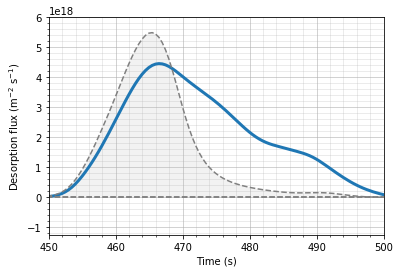

In [88]:
# compute total flux and trap contributions
derived_quantities = np.array((my_derived_quantities.data)[1:])

t = derived_quantities[:, 0]
flux_left = derived_quantities[:, -2]
flux_right = derived_quantities[:, -1]
flux_total = -flux_left - flux_right

contribution_trap_1 = -np.diff(derived_quantities[:, 3])/np.diff(t)
contribution_trap_2 = -np.diff(derived_quantities[:, 4])/np.diff(t)
contribution_trap_3 = -np.diff(derived_quantities[:, 5])/np.diff(t)

# plot
import matplotlib.pyplot as plt
plt.plot(t, flux_total, linewidth=3)
plt.plot(t[1:], contribution_trap_1, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_1, facecolor='grey', alpha=0.1)
plt.plot(t[1:], contribution_trap_2, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_2, facecolor='grey', alpha=0.1)
plt.plot(t[1:], contribution_trap_3, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_3, facecolor='grey', alpha=0.1)

plt.xlim(450, 500)
plt.ylim(bottom=-1.25e18, top=0.6e19)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")
plt.minorticks_on()
plt.grid(which='minor', alpha=0.3)
plt.grid(which='major', alpha=0.7)